# Indholdsfortegnelse
- [Indledning](#Indledning)
- [Indlæsning af Data og EDA](2#Indl%C3%A6sning-af-data-og-EDA)
- [Modeller](#Modeller)
  - [Baseline: en simpel tilgang](#1.-Baseline:-en-simpel-tilgang)
  - [Moving Average](#2.-Moving-Average)
    - [SMA](#Simple-moving-average)
    - [CMA](#Cumulative-Moving-Average)
    - [EMA](#Exponential-Moving-Average)
  - [Random Forest](#3.-Random-forest)
    - [Feature engineering](#Feature-engineering)
    - [Prediction](#Prediction)
  - [Sarimax](#4.-Sarimax)
    - [Trend og seasonality](#Trend-og-seasonality)
    - [Parameteranalyse](#Parameteranalyse)
    - [In sample prediction](#In-sample-prediction)
    - [Out of sample forecast](#Out-of-sample-forecast)
  - [Prophet](#5.-Prophet)
- [Scorer og tidsforbrug](#Scorer-og-tidsforbrug)

# **Indledning**
”M5 Forecasting – Accuracy” er en konkurrence på www.kaggle.com, hvor interesserede får stillet et datasæt for butikken Walmart’s salg over en årrække til rådighed, og ud fra dette skal forsøge at forudsige 28 dages salg. Dataen indeholder bl.a. information om salg pr. dag, vare, kategori, butik, stat mm., som deltagere kan inddrage i deres analyser og undersøgelser.

På baggrund af en indledende analyse og undersøgelse af opgaven samt data, er vores problemstilling følgende:

    ”Hvordan kan vi udnytte og implementere det, som vi har lært i undervisningen, til at forudsige Walmart’s salg i 28 dage?

På grund af køretiden på nogle af modellerne, har vi i flere tilfælde valgt at kompakte hele datasættet til et gennemsnit af alt salget - velviden at vi mister en masse finesser i datasættet på den bekostning.

# **Indlæsning af data og EDA**

In [1]:
# initial imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv


## Indlæs datoerne som datasættet er spredt ud over
Dette er for senere at kunne omdanne d_1, d_2 osv til rigtige datoer.

In [2]:
calendar_df = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv', parse_dates=['date'], usecols=['date','d'])

# udvælger kun de datoer som ligger i sales_train_validation

calendar_stv = calendar_df[:1913] 
calendar_stv.info()
del calendar_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1913 non-null   datetime64[ns]
 1   d       1913 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 30.0+ KB


## indlæs datasættet: sales_train_validation

In [3]:
sales_train_validation = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv', index_col='id')
sales_train_validation.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


## Hvad indeholder det?
og hvordan er data fordelt?

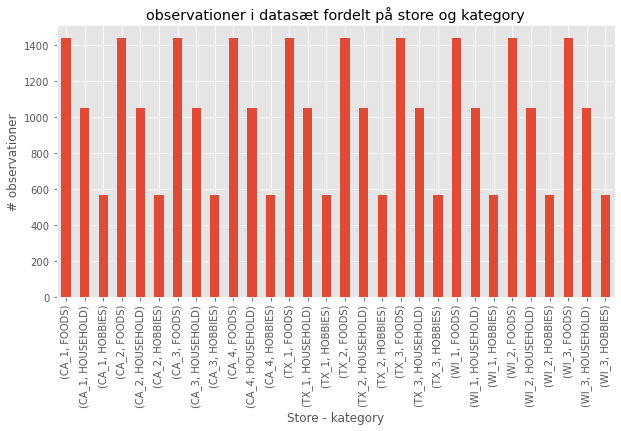

In [4]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 5]
ax = sales_train_validation.groupby(['store_id'])['cat_id'].value_counts().plot(kind='bar', title="observationer i datasæt fordelt på store og kategory")
ax.set_ylabel('# observationer')
ax.set_xlabel('Store - kategory')

plt.show()

Der er 10 butikker, 3 vare kategorier med et ens antal varer i:
- Foods, med 1437 varer
- Household, med 1047 varer
- Hobbies, med 565 varer

30490 rækker i datasættet svarer overens med:
`antal_butikker * ( antal_varer_foods + antal_varer_household + antal_varer_hobbies )`

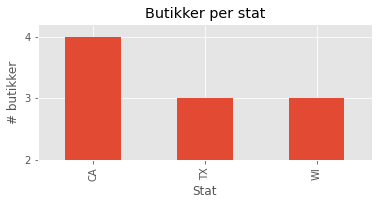

In [5]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [6, 2.5]
ax = sales_train_validation.groupby('state_id')['store_id'].nunique().plot(kind='bar', title="Butikker per stat")
ax.set_ylabel('# butikker')
ax.set_xlabel('Stat')
ax.set_ylim(bottom=2)
plt.yticks(np.arange(2,5,1))

plt.show()

Der er ialt 10 butikker - staten `CA` har en butik mere end de andre to stater

## Det samlede salg per stat 

In [6]:
aggregate_state_sum = sales_train_validation.groupby(by=['state_id'],axis=0).sum()
aggregate_state_sum.columns = calendar_stv['date']
agg_state_sum_trans = aggregate_state_sum.transpose()
del aggregate_state_sum

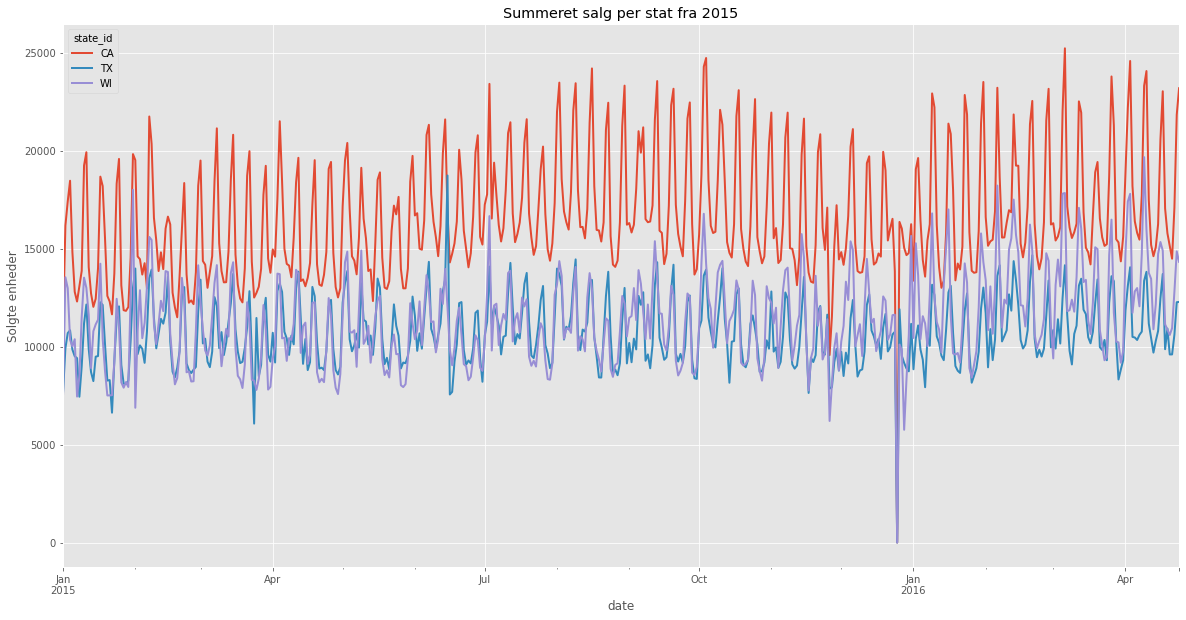

In [7]:
from_year = '2015'
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['lines.linewidth'] = 2
ax = agg_state_sum_trans[from_year:].plot(title="Summeret salg per stat fra {}".format(from_year))
ax.set_ylabel('Solgte enheder')
plt.show()
del agg_state_sum_trans

`CA` sælger flere enheder end de andre to stater. `TX` og `WI` følges nogenlunde ad.
- Husk at staten `CA` har en butik mere end de andre!
- Hvad sker der hvis man laver en graf med det gennemsnitlige salg?

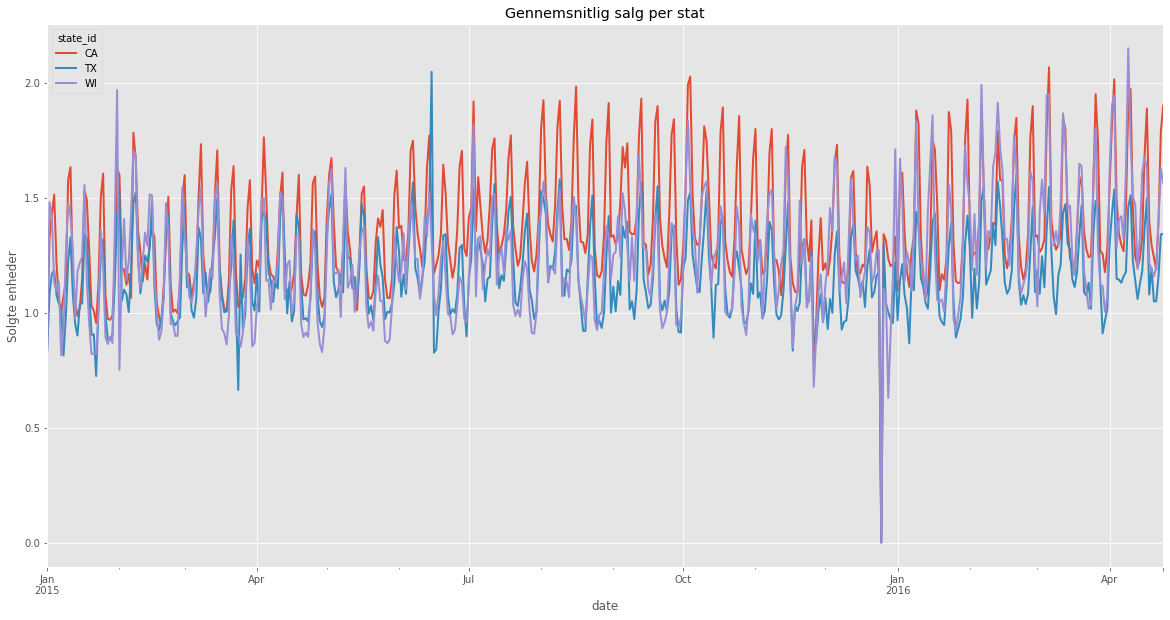

In [8]:
aggregate_state_mean = sales_train_validation.groupby(by=['state_id'],axis=0).mean()
aggregate_state_mean.columns = calendar_stv['date']
agg_state_mean_trans = aggregate_state_mean.transpose()
del aggregate_state_mean
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['lines.linewidth'] = 2
ax = agg_state_mean_trans['2015':].plot(title="Gennemsnitlig salg per stat")
ax.set_ylabel('Solgte enheder')
plt.show()
del agg_state_mean_trans

Når man kigger på salgsgennemsnittet følges de 3 stater mere ad, men `CA` er stadig umiddelbart førende.
- Måske er stat en faktor der kan hjælpe når der skal trænes en model.

## Salget per butik i en stat

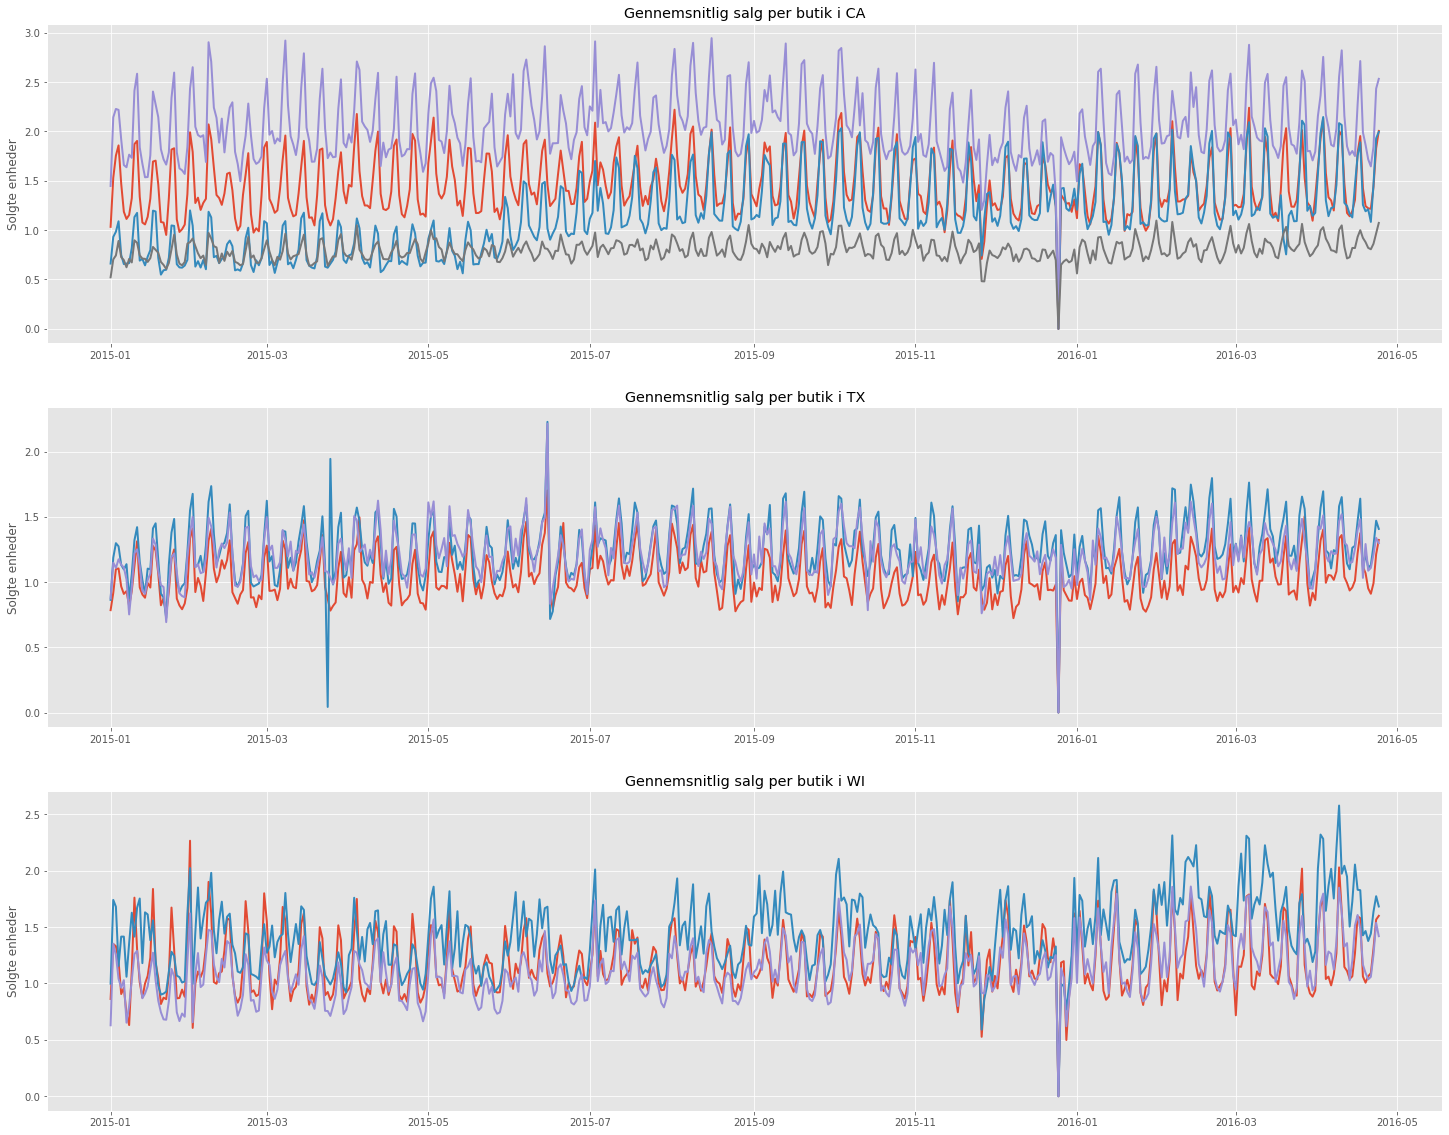

In [9]:

aggregate_state_mean = sales_train_validation.groupby(by=['state_id', 'store_id'],axis=0).mean()
aggregate_state_mean.columns = calendar_stv['date']
agg_state_mean_trans = aggregate_state_mean.transpose()
del aggregate_state_mean
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [25, 20]
plt.rcParams['lines.linewidth'] = 2
fig,ax = plt.subplots(3,1)
for i, state in enumerate(['CA','TX','WI'], start=0):
    ax[i].plot(agg_state_mean_trans['2015':][state])
    ax[i].set_title("Gennemsnitlig salg per butik i {}".format(state))
    ax[i].set_ylabel('Solgte enheder')
    i = i+1
plt.show()
del agg_state_mean_trans

I CA er der især forskel på gns salget på butikkerne med størt og mindst salg. Det kan variere med ca 2 enheder. I de andre stater følges butikkerne mere ad, men der er stadig forskelle.
- Det tyder på at 'store_id' måske kan indeholde nogle info vi kan bruge.
- `store_id` i sig selv er betydningsløst, men værdien kan måske indirekte sige noget om hvor stor et opland de enkelte butikker skal betjene.
  - Hvis en butik har en stor befolkning i nærområdet, er det oplagt at de folk benytter den butik.
  - Men ved at kigge på `store_id` i sig selv, er det ikke noget vi kan afgøre.
- `state_id` og `store_id` er to forskellige måder at opgøre geografisk placering på. `store_id` må antages at være mere præcist at bruge end `state_id`

## Fordeling af varekategorier i de 3 stater

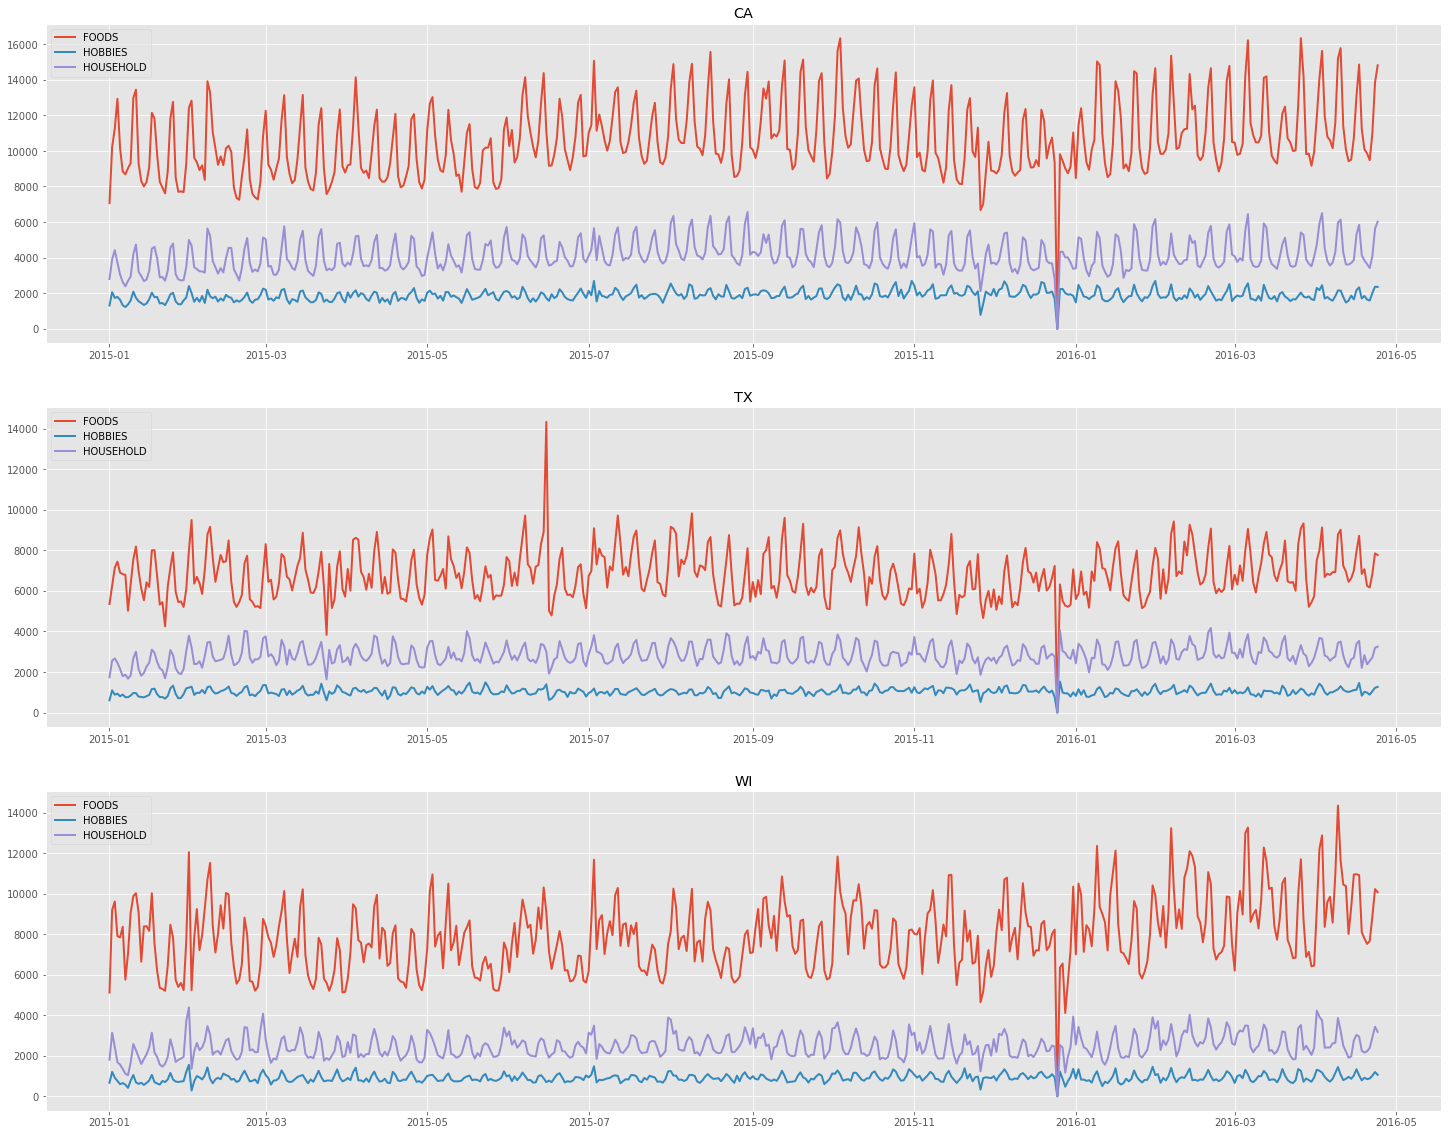

In [10]:
aggregate_state_category = sales_train_validation.groupby(by=['state_id', 'cat_id'],axis=0).sum()
aggregate_state_category.columns = calendar_stv['date']
agg_state_trans = aggregate_state_category.transpose()
del aggregate_state_category
fig,ax = plt.subplots(3,1)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [30, 25]
plt.rcParams['lines.linewidth'] = 2
#ax.legend()
ax[0].plot(agg_state_trans['CA']['2015':])
ax[0].set_title('CA')
ax[0].legend(('FOODS', 'HOBBIES', 'HOUSEHOLD'), loc='upper left')
ax[1].plot(agg_state_trans['TX']['2015':])
ax[1].set_title('TX')
ax[1].legend(('FOODS', 'HOBBIES', 'HOUSEHOLD'), loc='upper left')
ax[2].plot(agg_state_trans['WI']['2015':])
ax[2].set_title('WI')
ax[2].legend(('FOODS', 'HOBBIES', 'HOUSEHOLD'), loc='upper left')
plt.show()
del agg_state_trans

Alle 3 stater følger samme møster:
- størst salg af `Foods`
- `Household` kommer på andenpladsen
- `Hobbies` har mindst salg

Vare kategori kan have betydning for salg. Dette er dog ikke specielt overraskende, det virker logisk at der indkøbes flere varer i `FOODS`-kategorien, end i `HOUSEHOLD` og `HOBBIES`.

## Salget på underkategorier 

In [11]:

def plot_state_category(sales_train_validation, calendar_dates, state, category='ALL', start_time='2015'):
    sales_state_category = sales_train_validation.loc[sales_train_validation['state_id'] == state ]
    if category != 'ALL' :
        sales_state_category = sales_state_category.loc[sales_state_category['cat_id'] == category]
    aggregate_ssc = sales_state_category.groupby(by=['dept_id'],axis=0).mean()

    aggregate_ssc.columns = calendar_dates['date']

    agg_ssc_trans = aggregate_ssc.transpose()
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['lines.linewidth'] = 2
    ax = agg_ssc_trans[start_time:].plot(title="MEANed numbers State: {}, Category: {}".format(state, category))
    ax.set_ylabel('Units sold')
    plt.show()


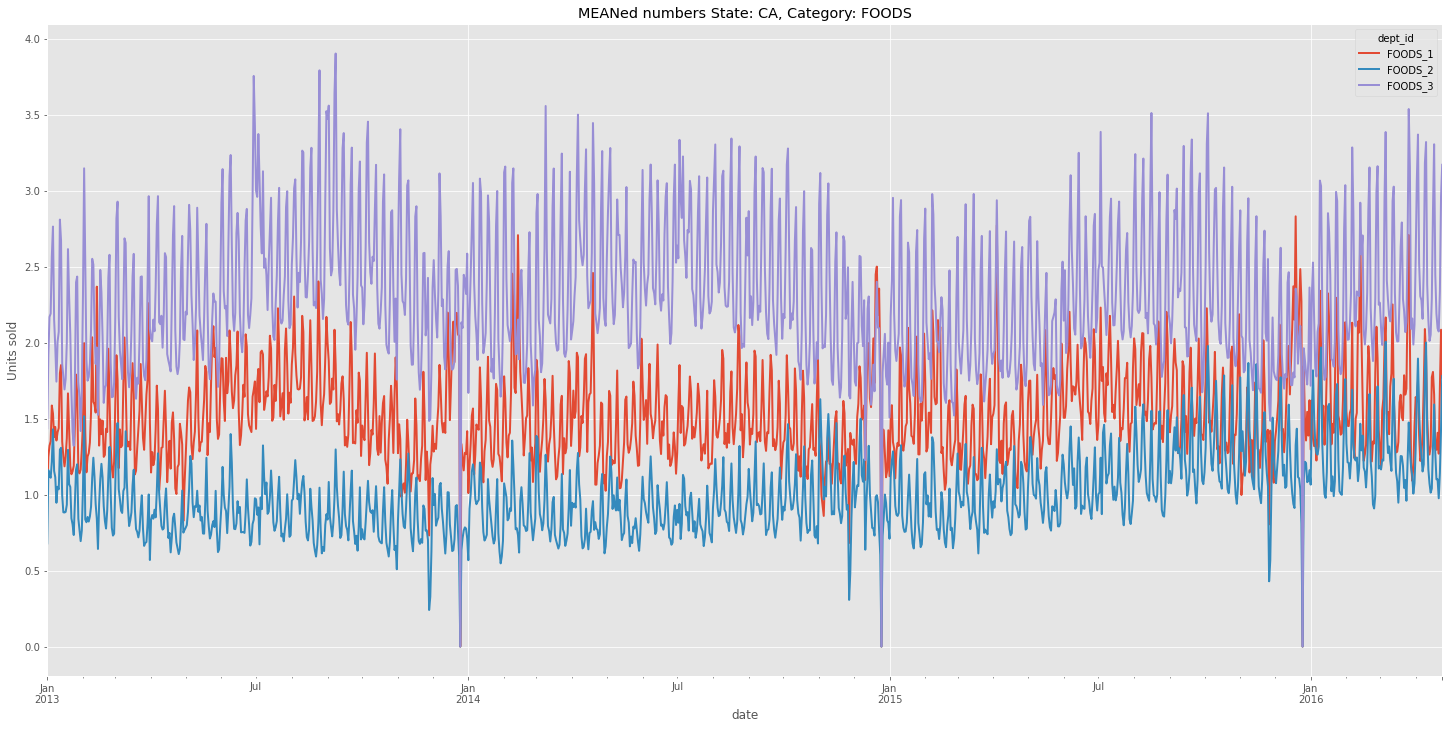

In [12]:
plot_state_category(sales_train_validation, calendar_stv, 'CA', category='FOODS', start_time='2013')

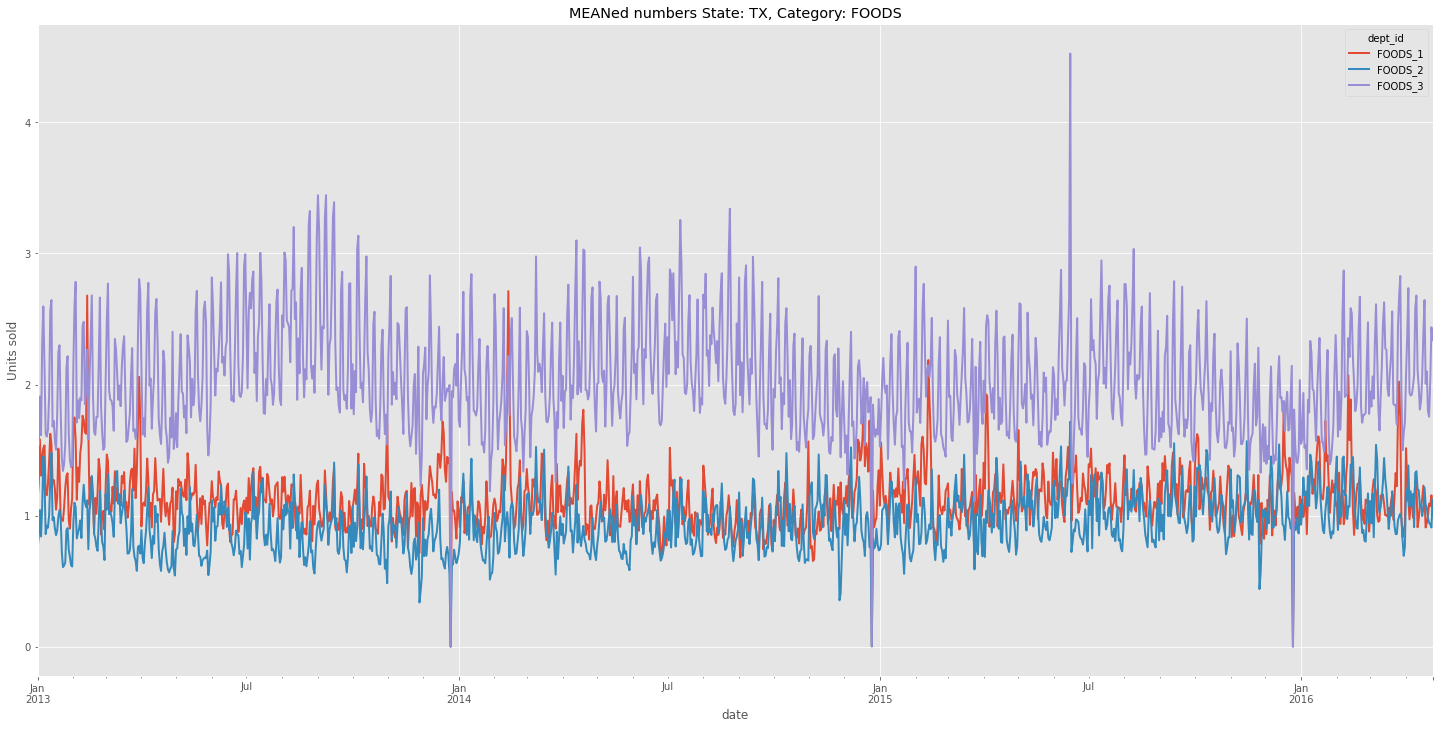

In [13]:
plot_state_category(sales_train_validation, calendar_stv, 'TX', category='FOODS',start_time='2013')

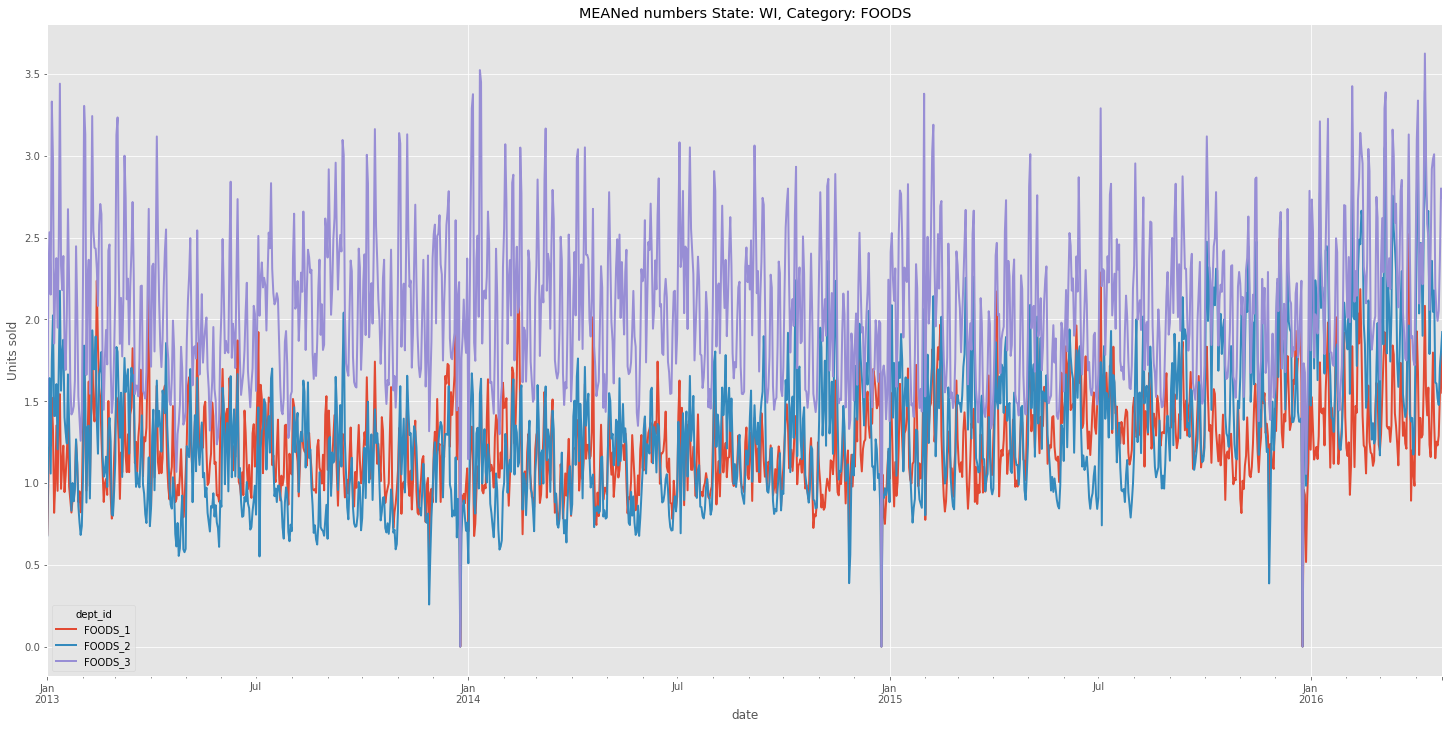

In [14]:
plot_state_category(sales_train_validation, calendar_stv, 'WI', category='FOODS', start_time='2013')

Sub kategorierne under foods ser også ud til at kunne vise nogle tendenser i antallet solgt under hver kategori.
- Overkategorien `cat_id` virker pludselig overføldig - underkategorierne indeholde samme information og mere endnu

## 25. december

In [15]:
light_sales = sales_train_validation.drop(['item_id','dept_id','cat_id','store_id'], axis=1)
light_sales = light_sales.groupby('state_id').mean()
light_sales.columns = calendar_stv['date']
light_s_t = light_sales.transpose()

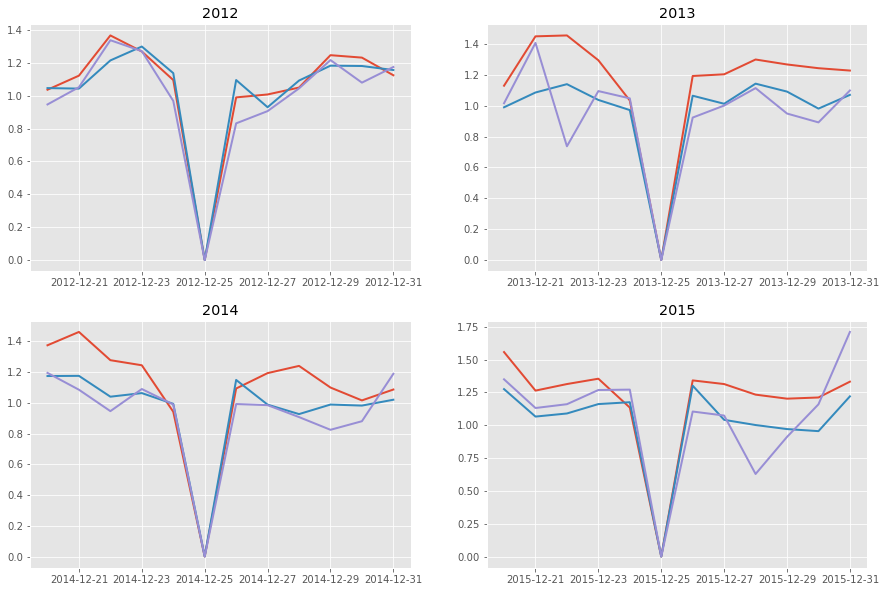

In [16]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 10]
fig, ax = plt.subplots(2,2)
ax[0][0].plot(light_s_t['20-12-2012':'31-12-2012'])
ax[0][0].set_title('2012')
ax[0][1].plot(light_s_t['20-12-2013':'31-12-2013'])
ax[0][1].set_title('2013')
ax[1][0].plot(light_s_t['20-12-2014':'31-12-2014'])
ax[1][0].set_title('2014')
ax[1][1].plot(light_s_t['20-12-2015':'31-12-2015'])
ax[1][1].set_title('2015')
plt.show()

Den 25. december hvert år er der intet salg på nogen kategorier - Amerikanerne fejrer jul, butikkerne er formentlig lukkede.

## Trend
Er der en stigende eller faldende tendens i det samlede datasæt?

In [17]:
sales_mean = sales_train_validation.mean()
sales_mean.index = calendar_stv['date']

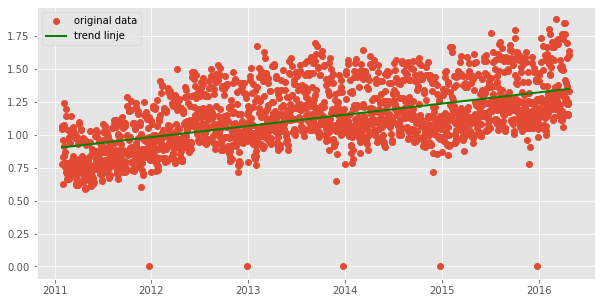

In [18]:
from scipy import stats
x= np.arange(0,len(sales_mean))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, sales_mean.values)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(sales_mean.index, sales_mean.values, 'o', label='original data')
plt.plot(sales_mean.index, intercept + slope*x, 'g', label='trend linje')
plt.legend()
plt.show()



Som man kan ane på den blå linje, er der en opadgående tendens på gennemsnittet af alt salget.

### Ugentlige udsving

In [19]:
store_dept = sales_train_validation.groupby(by= ['cat_id'], axis=0).mean()
store_dept.columns = calendar_stv['date']
store_trans = store_dept.transpose()
del store_dept

In [20]:
weekends = ['01-03-2015','01-04-2015','01-10-2015','01-11-2015','01-17-2015', '01-18-2015','01-24-2015', '01-25-2015', '01-31-2015', 
            '02-01-2015', '02-07-2015', '02-08-2015', '02-14-2015', '02-15-2015', '02-21-2015', '02-22-2015', '02-28-2015', 
            '03-01-2015', '03-07-2015', '03-08-2015', '03-14-2015', '03-15-2015', '03-21-2015', '03-22-2015', '03-28-2015',  '03-29-2015']

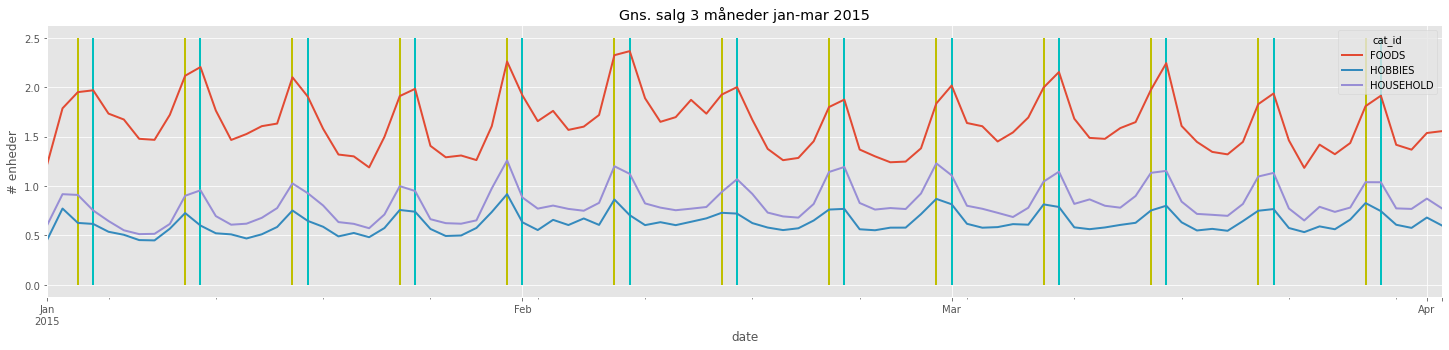

In [21]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [25, 5]
ax = store_trans['01-01-2015':'04-02-2015'].plot(title="Gns. salg 3 måneder jan-mar 2015")
ax.set_ylabel('# enheder')
ax.vlines(weekends, 0, 2.5, colors=['y','c'])
plt.show()

I ovenstående graf vises det gennemsnitlige salg på kategorierne. Hver lørdag/søndan er markeret med en vertikal streg.
- Gennemsnitssalget stiger typisk hver weekend. 

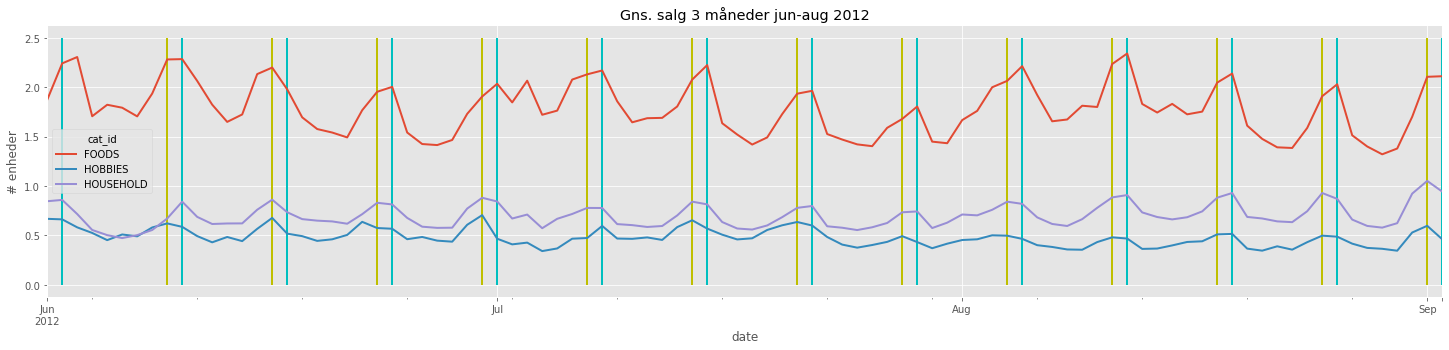

In [22]:
weekends= ['06-02-2012','06-02-2012','06-09-2012','06-10-2012', '06-16-2012','06-17-2012','06-23-2012', '06-24-2012', '06-30-2012', 
           '07-01-2012','07-07-2012','07-08-2012','07-14-2012', '07-15-2012','07-21-2012','07-22-2012', '07-28-2012', '07-29-2012', 
           '08-04-2012','08-05-2012','08-11-2012', '08-12-2012','08-18-2012','08-19-2012', '08-25-2012', '08-26-2012', '09-01-2012','09-02-2012'
            ]
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [25, 5]
ax = store_trans['06-01-2012':'09-02-2012'].plot(title="Gns. salg 3 måneder jun-aug 2012")
ax.set_ylabel('# enheder')
ax.vlines(weekends, 0, 2.5, colors=['y','c'])
plt.show()
del weekends

- Der er et lille opsving d. 3. juli (muligvis i forbindelse med 4. juli)
- Men ellers ser vi generelt samme tendens, nemlig at der indkøbes mere i weekenderne

## Opsamling på EDA

Ved at undersøge dataet er vi kommet frem til dette:
- Store_id er en mere finmasket version af state_id, vi vil kunne fjerne state_id fra et træningssæt da featuren er redundant
- dept_id er en mere finmasket version af cat_id, vi vil kunne fjerne cat_id fra et træningssæt, da featuren er redundant
- datasættet har en stigende trend
- Der er periodevise udsving i salget, der topper i weekenderne og er lavet midt på ugen.

# **Modeller**

In [23]:
#Indlæser data mm.
sales = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv', index_col='id')
sample = pd.read_csv('../input/m5-forecasting-accuracy/sample_submission.csv', index_col='id')

## **1. Baseline: en simpel tilgang**
Når man har læst opgaven grundigt, renset sin data og gjort sig nogle overvejelser om fremgangsmåde, vil man ofte forsøge at lave en form for baseline. En baseline er en meget simpel løsning/model, der kan bruges som udgangspunkt til mere komplekse løsninger; ikke i den forstand, at du nødvendigvis vil bygge videre på baselinen, men du kan bruge dens resultater til at sammenligne med de løsninger, du sidenhen udvikler, da disse gerne skulle give bedre resultater end baselinen.

Da opgaven kort sagt går ud på at forudsige 28 dages salg for diverse artikler i Walmart, ville en meget simpel baseline være at bruge de sidste 28 dages salg som vores forudsigelse/predictions. Rent matematisk kan det opstilles således: 

$ŷ_t=y_{t-28}$

$ŷ_t$ er den værdi, som vi forsøger at udregne/forudsige, og $y_t$ er den faktiske værdi. Det vil sige, at for hver værdi som vi forudsiger, så tager vi den faktiske værdi 28 dage forinden, ergo bruger vi de sidste 28 dages salg som vores forudsigelse.


In [24]:
#De sidste 28 dages salg
lastsales = sales.iloc[:,-28:]

In [25]:
#Laver et array fra "F1" til "F28" som er det påkrævede navneformat for kolonner
f_list = []
for num in np.arange(1,29):
    f_list.append("F{}".format(num))

#Sætter kolonnenavnene for de sidste 28 dages salg til det påkrævede navneformat
lastsales.columns = f_list

In [26]:
#Tilføjer det tomme evalueringsdata til vores salgsdata for at opnå det ønskede format
emptyevaluation = sample.tail(30490)
submission = pd.concat([lastsales, emptyevaluation])

submission.to_csv('baseline.csv')

##  **2. Moving Average**

En tilgang til data-analyse er at tage gennemsnittet af en delmængde af datasættet, også kaldet moving average. Man arbejder typisk med et ”vindue”, i dette tilfælde et vindue på et vist antal dage, hvor man så udregner gennemsnittet af værdierne inden for vinduet. Hvis man f.eks. arbejder med et vindue på syv dage, så vil den første værdi blive udregnet ud fra gennemsnittet af de syv første dage. Herefter rykker man vinduet en dag, således at man for næste dag får en gennemsnitsværdi, der nu ikke længere kigger på værdien for første dag, men fra anden dag og syv dage frem. Sådan fortsætter man gennem hele datasættet, indtil alle gennemsnitsværdier er udregnet.

Det er typisk brugbart til at udjævne uregelmæssige/kortsigtede tendenser og i stedet fokusere på langsigtede tendenser, hvilket navnet ”average” også indikerer.


Der findes forskellige former for moving averages. I denne opgave har vi besluttet os for at kigge på tre af de mest udbredte og populære former, nemlig simple moving average (SMA), cumulative moving average (CMA) og exponential moving average (EMA).

Det skal noteres, at dette ikke som sådan er en model/classifier, som forudsiger værdier. Vi har dog vurderet, at dette ville være en god forlængelse af baselinen til at undersøge, om gennemsnitsværdier og forskellige vægtninger af disse giver et mere præcist bud på udvikling.

Vi bruger Python-bibloteket ”pandas”, som stiller udregningsmetoder for alle disse til rådighed.


### Simple moving average
Ved simple moving average (SMA) har man et vindue på et fast/permanent antal dage. Hvis man f.eks. arbejder med en time series og med et vindue på syv dage, så vil den første værdi blive udregnet ud fra gennemsnittet af de syv første dage. Herefter rykker man vinduet en dag, således at man for næste dag får en gennemsnitsværdi, der nu ikke længere kigger på værdien for første dag, men fra anden dag og syv dage frem. Sådan fortsætter man gennem hele datasættet, indtil alle gennemsnitsværdier er udregnet.

I pandas kan man udregne SMA ved hjælp af funktionen .rolling(), som er tilgængelig for DataFrames. Her definerer man sit vindue vha. parametret ”window”. Vi har prøvet med forskellige værdier mellem 1 og 7, og det er med netop et vindue på 1, at det mest præcise resultat opnås. Funktionen bruges sammen med .mean()-metoden til at få gennemsnittet af hvert vindue. 

Et vindue på 1 svarer essentielt til at værdierne for de sidste 28 dage, altså giver det samme resultat som vores baseline gør. Et løbende gennemsnit af delsættene har altså ikke være været en forbedring fra vores baseline.

Det kunne muligvis have forbedret vores resultat at bruge en større del af datasættet end blot de sidste 28 dage.

In [27]:
#De sidste 28 dages salg
lastsales = sales.iloc[:,-28:]

In [28]:
#Vi gør her brug .rolling()-funktionen, som blev introduceret ovenfor.
SMA = lastsales.rolling(window=1, axis=1).mean()

In [29]:
#Laver et array fra "F1" til "F28" som er det påkrævede navneformat for kolonner
f_list = []
for num in np.arange(1,29):
    f_list.append("F{}".format(num))

#Sætter kolonnenavnene for de sidste 28 dages salg til det påkrævede navneformat
SMA.columns = f_list

In [30]:
#Tilføjer det tomme evalueringsdata til vores salgsdata for at opnå det ønskede format
emptyevaluation = sample.tail(30490)
submission = pd.concat([SMA, emptyevaluation])

In [31]:
submission.to_csv('SMA.csv')

### Cumulative Moving Average

Den anden form for moving average, som vi har besluttet os for at afprøve, er cumulative moving average (CMA). Her definerer man ikke et vindue som sådan, men har mulighed for at specificere, hvor mange værdier, der som minimum skal inkluderes til den første (og sågar også alle andre) gennemsnitsudregning. Når næste gennemsnitsudregning skal udføres, så bruger man stadig den første værdi, som nu ville ligge uden for vinduet i SMA, dvs. at man altid bruger alle tidligere værdier i udregningen. Ved den allersidste gennemsnitsudregning bruger man altså alle værdier.

I pandas udregnes CMA ved hjælp af .expanding()-funktionen. Denne har parameteret min_periods, som bruges til at definere det minimum antal værdier, der skal bruges til gennemsnitsudregningerne.

Her har vi valgt at bruge hele datasættet for at få så præcist et kumulativt gennemsnit som muligt. Vi har sat min_periods til 7 dage, da vi i vores data-undersøgelse fandt frem til ugentlig udsving i weekenderne, hvorfor det er relevant at have en hel uges data med som minimum.

Den kumulative tilgang forbedrede ikke resultatet ift. SMA.

In [32]:
#Vi gør her brug .expanding()-funktionen, som blev introduceret ovenfor.
sales_CMA = sales.expanding(min_periods=7, axis=1).mean()

In [33]:
#Vi tager CMA-værdierne for de sidste 28 dage
CMA = sales_CMA.iloc[:,-28:]

In [34]:
#Laver et array fra "F1" til "F28" som er det påkrævede navneformat for kolonner
f_list = []
for num in np.arange(1,29):
    f_list.append("F{}".format(num))

#Sætter kolonnenavnene for de sidste 28 dages salg til det påkrævede navneformat
CMA.columns = f_list

In [35]:
#Tilføjer det tomme evalueringsdata til vores salgsdata for at opnå det ønskede format
emptyevaluation = sample.tail(30490)
submission = pd.concat([CMA, emptyevaluation])

In [36]:
submission.to_csv('CMA.csv')

### Exponential Moving Average

Exponential moving average (EMA) tildeler større vægt til nyere værdier end gamle værdier, dvs. at jo ældre datoen for en observeret værdi er, des mindre vil den påvirke gennemsnitsudregningen. Derfor kan man også antage, at den vil give et mere præcist bud end CMA-fremgangen.

I pandas er det muligt at udregne EMA vha. .ewm()-funktionen. Særligt for den er, at man skal sætte en såkaldt ”lagged” værdi/variabel, altså en variabel som indeholder værdierne for tidligere tidspunkter. I .ewm()-funktionen er det f.eks. muligt at sætte en lagged variabel vha. parametret span. Da vi som beskrevet tidligere har observeret en ugentlig trend i datasættet, ville det være oplagt at sætte parametret til syv; derved lægges der særligt vægt på de syv foregående dage i gennemsnitsudregningerne, hvor den nyeste dag af de syv igen får tildelt særlig vægt, og den ældste af de syv dage får tildelt mindst vægt (ud af de syv).

Den eksponentielle tilgang resulterede i en væsentlig forbedring fra CMA, men forbedrede ikke resultat fra ift. SMA. 

In [37]:
#Vi gør her brug .ewm()-funktionen, som blev introduceret ovenfor.
sales_EMA = sales.ewm(span=7, axis=1).mean()

In [38]:
#Vi tager EMA-værdierne for de sidste 28 dage
EMA = sales_EMA.iloc[:,-28:]

In [39]:
#Laver et array fra "F1" til "F28" som er det påkrævede navneformat for kolonner
f_list = []
for num in np.arange(1,29):
    f_list.append("F{}".format(num))

#Sætter kolonnenavnene for de sidste 28 dages salg til det påkrævede navneformat
EMA.columns = f_list

In [40]:
#Tilføjer det tomme evalueringsdata til vores salgsdata for at opnå det ønskede format
emptyevaluation = sample.tail(30490)
submission = pd.concat([EMA, emptyevaluation])

In [41]:
submission.to_csv('EMA.csv')

## **3. Random forest**

Random forest er en af de mest kendte algoritmer. Den gør brug af det der kaldes decision trees. Det vil sige en data struktur hvor den ud fra noget input kan løbe igennem forgreninger for at finde det korrekte svar.

Når man taler om random forest, taler man om mange forskellige decisions trees oprettet på baggrunden en masse random valgt subsets af data. Man løber så noget input igennem alle disse træer og ser hvad output
alle træerne til sammen hælder mest til.

En random forest er kendt for at være let at arbejde med, intuitiv og forholdsvist præcis til klassificerings problemer. Den kan dog også bruges som en regressor som er det vi vil se på nu.

Vi indlæser dataen til pandas dataframe, og tager datoerne ud for calendar.csv filen

In [42]:
df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv', parse_dates=['date'], usecols=['date', 'd'])


### Feature engineering
Vi er nød til at omdanne de forskellige salg om til et let læsbar format for en random forest. Vi antager at X (features) modellen skal have er month, year og day. Alle repræsenteret som heltal. Y-værdien (target) er det salg vi har fået den pågældende dag. Det vil sige at for at vores model kan predicte et salg, er det eneste den skal have en dato. 

For at simplificere brugen af Random Forest gør vi her brug af et gennemsnit for alt i sales_train_validation sættet. 

En anden mulighed er at predicte hvert salg for hvert item i sales_train_validation. Dette er også kravet for selve konkurrencen. Da vi dog vil sammenligne forskellige algoritmer og se hvordan de performer på samme dataset, vælger vi her at gøre det for gennemsnittet af alt salg. 

In [43]:
sales = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv")
calendar_stv = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv", parse_dates=['date'])
# .mean() fjerner alle kolonner hvor det ikke er muligt at tage et gennemsnit på. 
sales_mean = sales.mean()
sales_mean.index = calendar_stv['date'][:1913]
# Vi transposer for at få vendt dataframen om. Dette gør selve datoen til index. 
sales_mean_trans = sales_mean.transpose()
actual = pd.DataFrame(data=sales_mean_trans)
actual.columns = ['y']
# Vi deler index op i tre kolonner ud fra måned, dag og år. 
actual['month'] = actual.index.month
actual['year'] = actual.index.year
actual['day'] = actual.index.day

### Prediction

In [44]:
# For at vi kan teste hvor godt modellen performer er vi nød til at tage de sidste 28 dage fra træningssættet og gemme de sidste 28 dage i et test set. 
training = actual[:-28]
test = actual[-28:]

In [45]:
from sklearn.ensemble import RandomForestRegressor

y = training['y'].values
X = training.drop('y', axis=1)
X_test = test.drop('y', axis=1)
Y_test = test['y'].values

In [46]:
%%time
rf = RandomForestRegressor()
model = rf.fit(X, y)
y_pred = model.predict(X_test)
y_pred

CPU times: user 402 ms, sys: 2.91 ms, total: 405 ms
Wall time: 405 ms


array([1.58475664, 1.43380813, 1.52381273, 1.56316015, 1.23299475,
       1.25011643, 1.33138504, 1.2995487 , 1.54624254, 1.80106789,
       1.43480485, 1.26025615, 1.23884388, 1.26723549, 1.39432929,
       1.5820023 , 1.63585602, 1.45066809, 1.35092391, 1.23865169,
       1.19255494, 1.28406297, 1.42203739, 1.51168252, 1.34342506,
       1.20670154, 1.15741719, 1.15486586])

For at se hvor godt modellen perfomer laver vi her en RMSE (Root mean squared error). 

In [47]:
np.mean((Y_test - y_pred)**2)**0.5

0.35964049534854275

## **4. Sarimax**
Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
- Vi har ikke brugt X'et :)

### Trend og seasonality
Hvis man skal bruge AR og MA komponenterne af Sarimax, skal vi først sørge for at data er stationary.
Vi afdækkede en trend i data under EDA, hvilket betyder at vi lige skal lave lidt arbejde på datasættet før vi kan hoppe ud i nogle predictions.

In [48]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [49]:
calendar_df = pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv', parse_dates=['date'], usecols=['date','d'])
sample_sub = pd.read_csv('../input/m5-forecasting-accuracy/sample_submission.csv', index_col='id')

# udvælger kun de datoer som ligger i sales_train_validation

calendar_stv = calendar_df[:1913]
sales = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv', index_col='id')
del calendar_df

In [50]:
sales_mean = sales.mean()
sales_mean.index = calendar_stv['date']

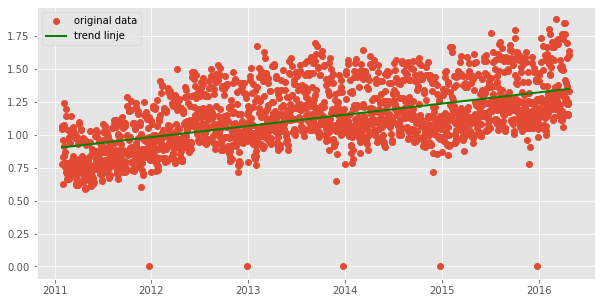

In [51]:
x= np.arange(0,len(sales_mean))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, sales_mean.values)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(sales_mean.index, sales_mean.values, 'o', label='original data')
plt.plot(sales_mean.index, intercept + slope*x, 'g', label='trend linje')
plt.legend()
plt.show()

Ved at bruge diff() på datasættet kan vi fjerne den opadgående trend

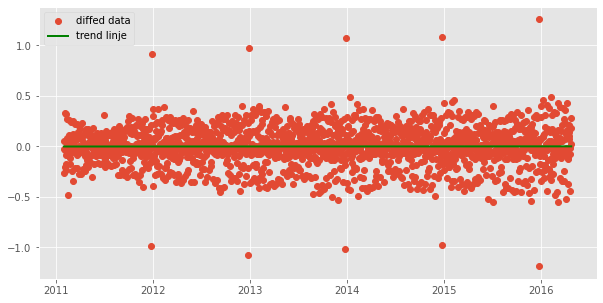

In [52]:
diffed = sales_mean.diff().dropna()
x= np.arange(0,len(diffed))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, diffed.values)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(diffed.index, diffed.values, 'o', label='diffed data')
plt.plot(diffed.index, intercept + slope*x, 'g', label='trend linje')
plt.legend()
plt.show()

Ved yderligere at bruge diff(7) på datasættet bearbejder vi også sæsonkomponenten (vi kunne se et gentagende mønster på 7 dage under EDA)

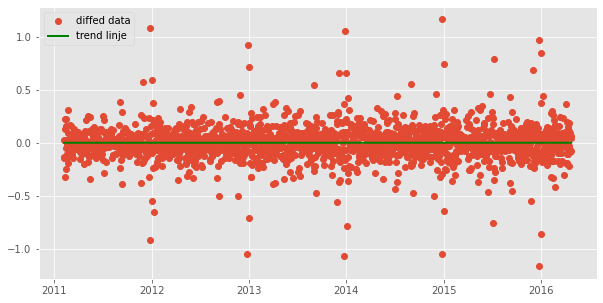

In [53]:
diffed_season = diffed.diff(7).dropna()
x= np.arange(0,len(diffed_season))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, diffed_season.values)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 5]
plt.plot(diffed_season.index, diffed_season.values, 'o', label='diffed data')
plt.plot(diffed_season.index, intercept + slope*x, 'g', label='trend linje')
plt.legend()
plt.show()

In [54]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(sales_mean_trans)
print('ingen dif')
print('  ADF Statistic: {}'.format(results[0]))
print('  p-value: {}'.format(results[1]))
results = adfuller(diffed)
print('diffed')
print('  ADF Statistic: {}'.format(results[0]))
print('  p-value: {}'.format(results[1]))
results = adfuller(diffed_season)
print('diffed+seasonal diffed 7 dage')
print('  ADF Statistic: {}'.format(results[0]))
print('  p-value: {}'.format(results[1]))
results = adfuller(diffed.diff(30).dropna())
print('diffed+seasonal diffed 30 dage')
print('  ADF Statistic: {}'.format(results[0]))
print('  p-value: {}'.format(results[1]))
results = adfuller(diffed.diff(365).dropna())
print('diffed+seasonal diffed 365 dage')
print('  ADF Statistic: {}'.format(results[0]))
print('  p-value: {}'.format(results[1]))

ingen dif
  ADF Statistic: -1.565373325331868
  p-value: 0.5009604361797637
diffed
  ADF Statistic: -23.45957882063262
  p-value: 0.0
diffed+seasonal diffed 7 dage
  ADF Statistic: -21.338292314725166
  p-value: 0.0
diffed+seasonal diffed 30 dage
  ADF Statistic: -11.042515127030361
  p-value: 5.322039147165551e-20
diffed+seasonal diffed 365 dage
  ADF Statistic: -12.501322554946288
  p-value: 2.802373407613916e-23


Hvis p-værdien er under 0.05 indenholder datasættet ikke nogen trend længere
- uden at diffe data er p-value 0.5, så her tyder det også statistisk på at der er en trend.
- ved første diff ryger vi pænt under 0.5
Da jeg ved at der er en sæson komponent i data, plotter jeg mine acf og pacf med det diffede sæt

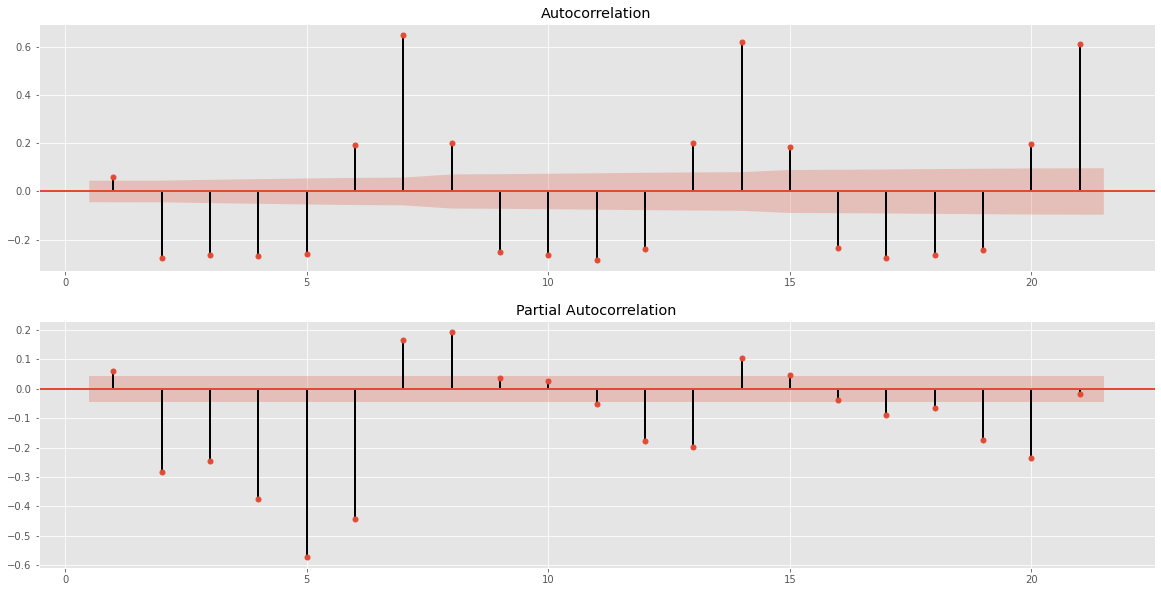

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig,(ax1, ax2) = plt.subplots(2,1, figsize=(20,10))
plot_acf(diffed, zero=False, ax=ax1, lags=21)
plot_pacf(diffed, zero=False, ax=ax2, lags=21)
plt.show()

Diffet datasæt - generel trend er fjernet
- Ved at kigge på ACF tyder det på at en mønster gentages for hver 7 dage
- Vi prøver at fjerne det mønster:

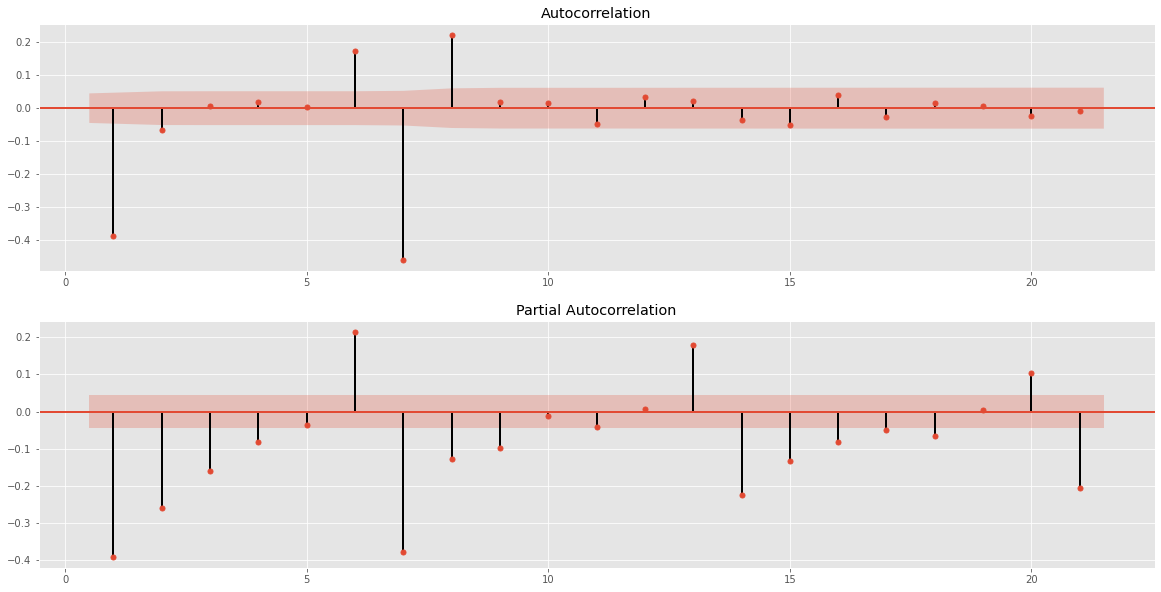

In [56]:
diffed_7 = diffed.diff(7).dropna()
fig,(ax1, ax2) = plt.subplots(2,1, figsize=(20,10))
plot_acf(diffed_7, zero=False, ax=ax1, lags=21)
plot_pacf(diffed_7, zero=False, ax=ax2, lags=21)
plt.show()

på nuværende tidspunkt er datasættet blevet diffet en gang og en gang med en sæson på 7.

### Parameteranalyse

SARIMAX består af parametrene (p,d,q)(P,D,Q)s
- d og D og s værdierne kender vi:
  - d=1 da datasættet skal diffes for at fjerne trenden
  - D=1 fordi vi har obseveret seasonality
  - s=7 fordi vi har sat seasonality til en uge
- På acf-grafen kan man umiddelbart aflæse antallet af lags der skal bruges i MA(q)
  - q=2
- på pacf-grafen kan man umiddelbart aflæse antallet af lags på AR(p)
  - p=4
- Så mangler vi P og Q værdierne:

Nu plotter vi acf og pacf med lags der svarer til intevaller på 7 dage

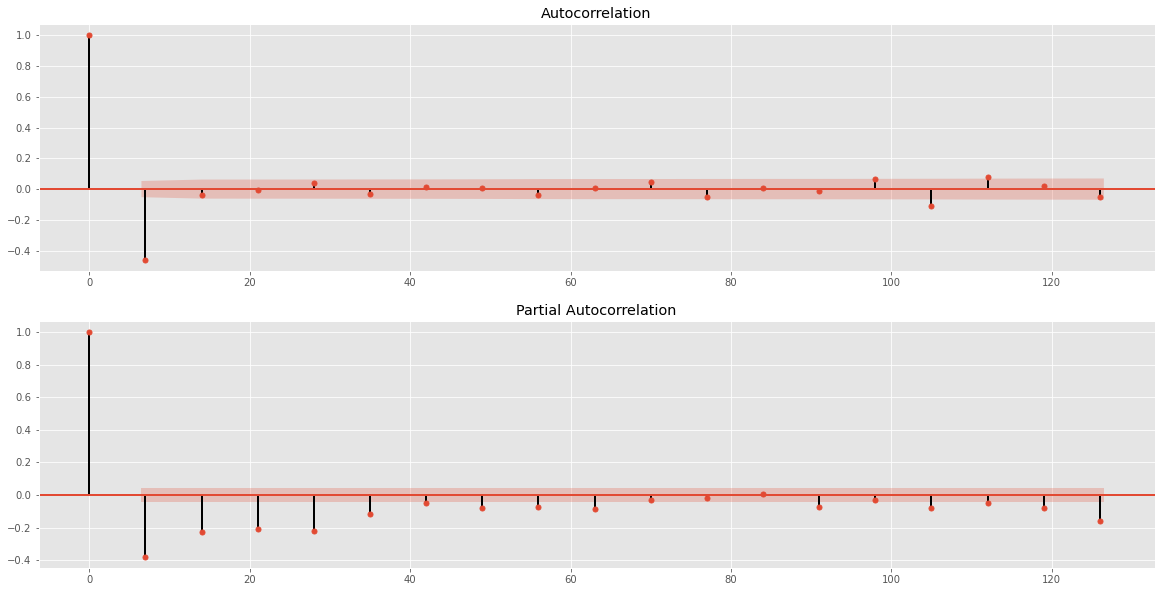

In [57]:
fig,(ax1, ax2) = plt.subplots(2,1, figsize=(20,10))
normal_lags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
lags7 =  [element * 7 for element in normal_lags]

plot_acf(diffed_7, lags=lags7, ax=ax1)
plot_pacf(diffed_7, lags=lags7, ax=ax2)
plt.show()

De samme principper gælder som ved p,q værdierne: P aflæses på pacf og Q aflæses på acf
- Q = 1, lag 0 sæller ikke med som en faktor
- P = 5,6 måske 9 
  - Grafen er mere tvetydig for aflæsning

### In sample prediction

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to conve

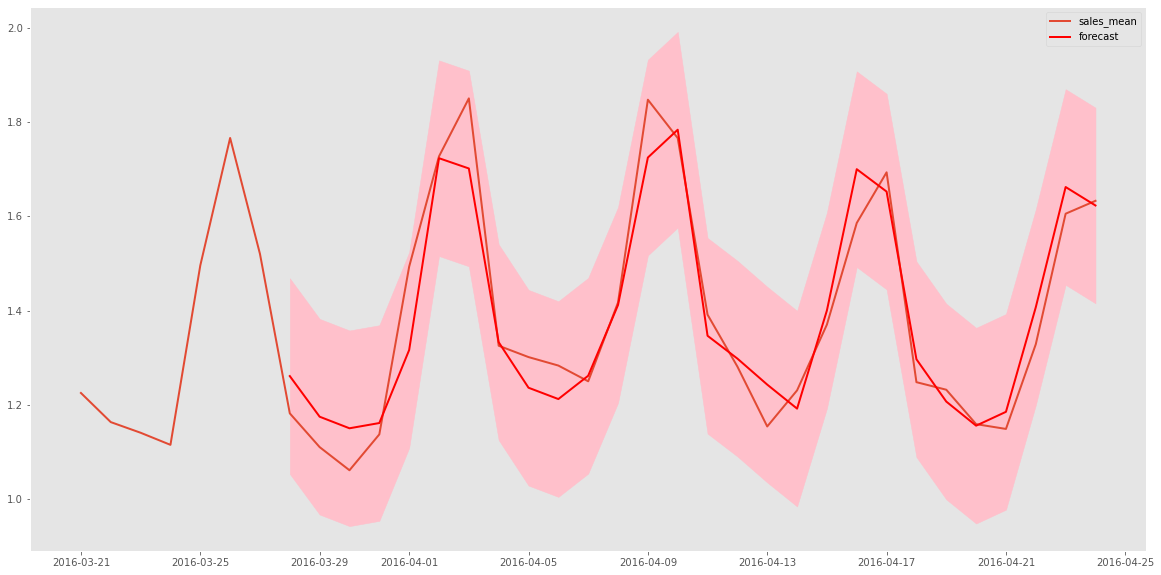

CPU times: user 2min 8s, sys: 3.34 s, total: 2min 12s
Wall time: 1min 6s


In [58]:
%%time
model = SARIMAX(sales_mean, order=(4,1,2), seasonal_order=(5,1,1,7))
results = model.fit()
forecast = results.get_prediction(start=-28)
mean_forecast_is = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

#confidence_intervals
lower_limits = confidence_intervals.loc[:,'lower y']
upper_limits = confidence_intervals.loc[:,'upper y']
plt.figure(figsize=(20,10))
#Plot prediction
plt.plot(sales_mean[-35:].index, sales_mean[-35:].values, label='sales_mean')
plt.plot(mean_forecast_is.index,
         mean_forecast_is.values,
         color='red',
         label='forecast')
#shade uncertainty area
plt.fill_between(mean_forecast_is.index, lower_limits, upper_limits, color='pink')
plt.legend()
plt.grid()
plt.show()

In [59]:
#mean_forecast
RMSE_insample = np.mean((sales_mean[-28:] - mean_forecast_is)**2)**0.5
print("Sarimax(4,1,2)(5,1,1)7\n - RMSE score: {}\n - fitting Tid: {}".format(RMSE_insample, '60 sekunder'))

Sarimax(4,1,2)(5,1,1)7
 - RMSE score: 0.07029513076995139
 - fitting Tid: 60 sekunder


### Out of sample forecast
Jeg skal have splittet mit data op så jeg kan foretage en form for kontrol med kvaliteten af data:
- `train` indeholder alt data - minus de sidste 28 dage
- `test` indeholder kun de sidste 28 dage

Jeg bruger `train` til at fitte min model og predicte de næste 28 dage frem.

In [60]:
test = sales_mean[-28:]
train = sales_mean[:-28]

In [61]:
%%time
model = SARIMAX(train, order=(4,1,2), seasonal_order=(5,1,1,7))
results = model.fit()
print(results.aic, results.bic)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to conve

-3024.353784673496 -2952.3671941978714
CPU times: user 2min 10s, sys: 3.4 s, total: 2min 13s
Wall time: 1min 6s


In [62]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1885
Model:             SARIMAX(4, 1, 2)x(5, 1, [1], 7)   Log Likelihood                1525.177
Date:                             Fri, 22 May 2020   AIC                          -3024.354
Time:                                     12:46:31   BIC                          -2952.367
Sample:                                 01-29-2011   HQIC                         -2997.837
                                      - 03-27-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6029      0.085     -7.132      0.000      -0.769      -0.437
ar.L2          0.3616      

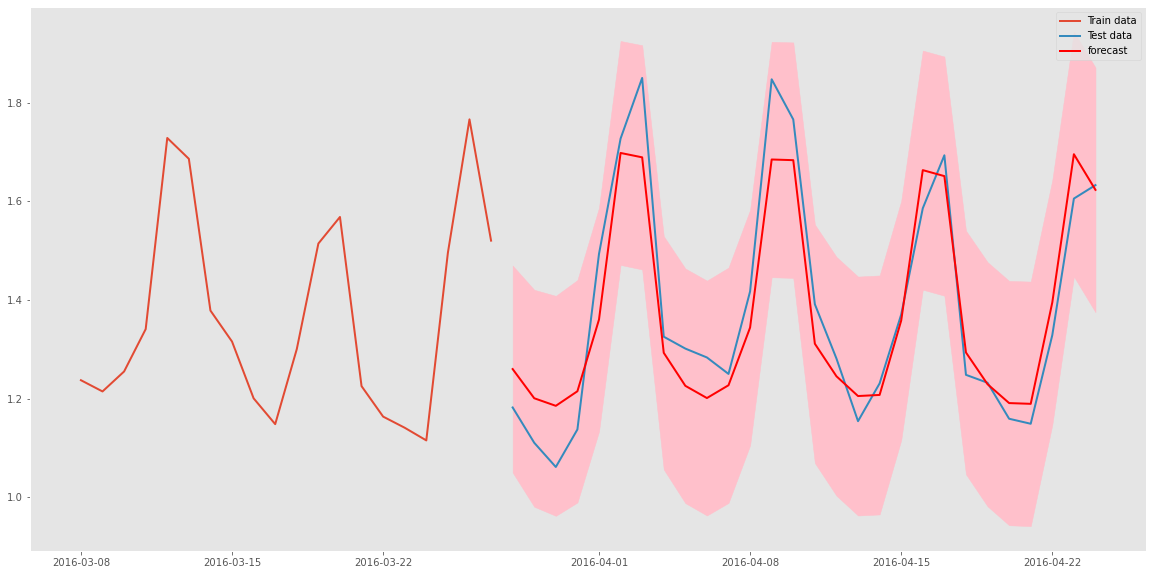

In [63]:
forecast = results.get_prediction(start='28-03-2016', end='24-04-2016', dynamic=True)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

#confidence_intervals
lower_limits = confidence_intervals.loc[:,'lower y']
upper_limits = confidence_intervals.loc[:,'upper y']
plt.figure(figsize=(20,10))
#Plot prediction
plt.plot(train[-20:].index, train[-20:].values, label='Train data')
plt.plot(test.index, test.values, label='Test data')
plt.plot(mean_forecast.index,
         mean_forecast.values,
         color='red',
         label='forecast')
#shade uncertainty area
plt.fill_between(mean_forecast.index, lower_limits, upper_limits, color='pink')
plt.legend()
plt.grid()
plt.show()

Umiddelbart på grafen ser det nogen lunde ud. Den røde streg - vores prediction - ligger relativt tæt på test.


In [64]:
#mean_forecast
RMSE = np.mean((test - mean_forecast)**2)**0.5
print("Sarimax(4,1,2)(5,1,1)7\n - RMSE score: {}\n - fitting Tid: {}".format(RMSE, '60 sekunder'))

Sarimax(4,1,2)(5,1,1)7
 - RMSE score: 0.07768605386189438
 - fitting Tid: 60 sekunder


En sammenligning af RMSE scoren på out of sample og in sample viser at modellen er nogenlunde stabil - den var forventeligt lidt bedre på insample data.

In [65]:
print('RMSE in sample:     {}\nRMSE out of sample: {}'.format(RMSE_insample, RMSE))

RMSE in sample:     0.07029513076995139
RMSE out of sample: 0.07768605386189438


## **5. Prophet**

Her ses et eksempel på brug af prophet. Prophet er en machine learning algoritme udviklet af Facebook til at lave timeseries forecasts.

Målet med denne algoritme er, at sænke kompleksiteten for timeseries forecasting og gøre brug af den syntaks der allerede eksistere i sklearn (.fit(), .predict())

Prophet er en algoritme der grundlæggende har følgende formel: y(t) = g(t) + s(t) + h(t) + e(t).

Hvor y(t) er det pågældende tid vi forudsiger.

g(t) er trenden.

s(t) er seasonality.

h(t) er holiday.

e(t) er errors vi ikke kan tage højde for.

Det er derfor flere forskellige modeller, der udgør prophet. Det er altså det der kaldes en additive model. 

Prophets hovedfokus er indenfor den branchen facebook er i, det vil sige menneskeskabt data. Derfor følger prophet pr. default nogle standard værdier der er typisk for et menneske (5. dages arbejdsuge, forskellige ferier osv.). Da det er en machine learning algoritme giver det selvfølgelig mening, at kigge på at hypertune alle de mulige parametre. 

Nedestående er et eksempel på en implementering af prophet.

Vi starter med at rense dataen, og tage højde for de events der er placeret i calendar. 

In [66]:
sales = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv")
calendar = pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv", parse_dates=['date'])
sales_mean = sales.mean()
sales_mean.index = calendar['date'][:1913]
sales_mean_trans = sales_mean.transpose()

Prohpet har mulighed for at bruge events / holidays. I dette tilfælde tager vi alle de datoer hvor der er et event på. Denne dataframe kan sættes som parametre når modellen skal predicte.

In [67]:
df_ev_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': calendar[~calendar['event_name_1'].isna()]['date']})
df_ev_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': calendar[~calendar['event_name_2'].isna()]['date']})
holidays = pd.concat((df_ev_1, df_ev_2))
del df_ev_1
del df_ev_2
del calendar

Prophet kræver at dataframen har et hvis format. Dataen skal have to kolonner, hhv. en ds-kolonne for DateStamp og en y kolonne for dit target. 

In [68]:
ds = sales_mean_trans.index.values
y = sales_mean_trans.values
test = pd.DataFrame(columns=['ds', 'y'])
test['ds'] = ds
test['y'] = y

Vi træner på de kendte data undtagen de sidste 28 dage. Disse dage bruger vi til at teste hvor godt vores model scorer tilsidst.

In [69]:
training = test[:-28]
actual = test[-28:]

In [70]:
%%time
from fbprophet import Prophet
# Vi sender holidays ind som parametre.
model = Prophet(holidays = holidays)
model.fit(training)
forecast = model.make_future_dataframe(periods=28, include_history=False)
forecast = model.predict(forecast)

CPU times: user 5.36 s, sys: 125 ms, total: 5.49 s
Wall time: 5.84 s


In [71]:
y_pred = forecast['yhat']
y_actual = actual['y']
y_actual = y_actual.reset_index()['y']

Vi lavere en RMSE for at se hvor godt vores model performet. 

In [72]:
np.mean((y_actual - y_pred)**2)**0.5

0.10888790341050435

# **Scorer og tidsforbrug**
- Tidsforbruget er fitting på gennemsnitssalget
- RMSE score 

In [73]:
score_dict = {
    'naive t-28': [0.10098, 2.0e-3],
    'Moving Average': [1.0942477597466052e-15, 0.0002],
    'SARIMAX': [0.07044, 60],
    'Prophet': [0.08670, 3.47],
    'Random Forrest': [0.35538,0.326]
}

scores = pd.DataFrame(data=score_dict)
scores.index = ['RMSE', 'seconds']
#scores

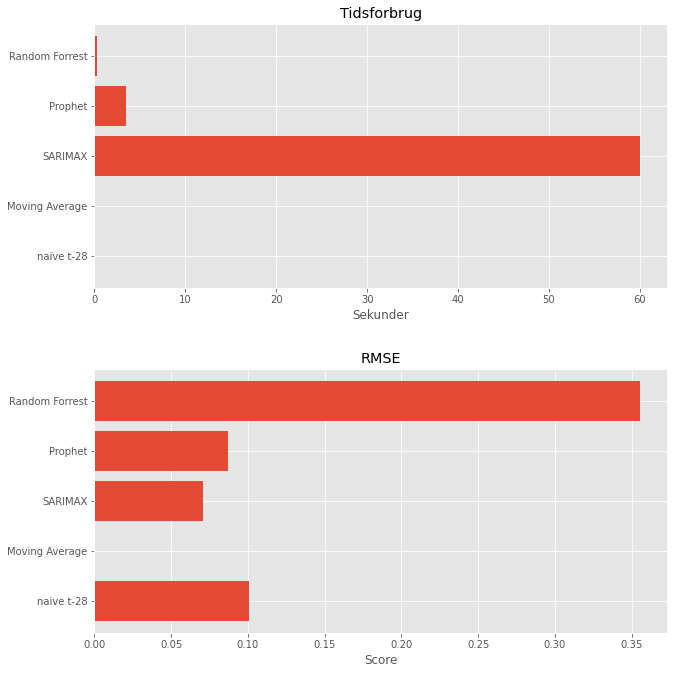

In [74]:
x = np.arange(3)
fig, (ax,a2) = plt.subplots(2,1,figsize=(10,10))
ax.barh(scores.columns,scores.loc['seconds'])
ax.set_title('Tidsforbrug')
ax.set_xlabel('Sekunder')
a2.barh(scores.columns, scores.loc['RMSE'])
a2.set_title('RMSE')
a2.set_xlabel('Score')
fig.tight_layout(pad=3.0)
plt.show()
